<a href="https://colab.research.google.com/github/secutron/TesTime/blob/main/AL21Test_AugTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import datetime
import datetime
print("Current Date/Time: ",  datetime.datetime.now())

Current Date/Time:  2021-04-26 01:35:24.942296


In [2]:
import albumentations

class Albumentation():
    def __init__(self):
        self.Albumentation_transform = albumentations.Compose([
                albumentations.PadIfNeeded(40,40,cv2.BORDER_REFLECT,True),
                albumentations.RandomCrop(32,32,True),                                         
                albumentations.HorizontalFlip(p=0.5),
                #albumentations.RandomRotate90(True),
                #albumentations.Rotate(-20,20),
                albumentations.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
                albumentations.Cutout(1,16,16,True),
                ToTensor(),
            ])
   
         
    def __call__(self,image):
        image_numpy = np.array(image)
        augmented = self.Albumentation_transform(image=image_numpy)
        image = augmented['image']
        return image    

In [3]:
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

from albumentations.pytorch import ToTensor

train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]
)


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)


# Train set with albumentation
trainset_with_Albumentation = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=Albumentation())


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)


labels = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
label2index = dict([(label, n) for n, label in enumerate(labels)])
index2label = dict(enumerate(labels))


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)


dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

dataloader_args_Albumentation = dict(shuffle=True, batch_size=4, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)


# train dataloader
train_loader = torch.utils.data.DataLoader(trainset, **dataloader_args)


train_loader_Albumentation = torch.utils.data.DataLoader(trainset_with_Albumentation, **dataloader_args)

# To view images
train_loader_Alb = torch.utils.data.DataLoader(trainset_with_Albumentation, **dataloader_args_Albumentation)

# test dataloader
test_loader = torch.utils.data.DataLoader(testset, **dataloader_args)


CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 deer   car horse   dog


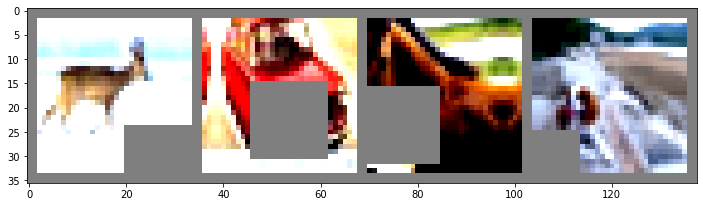

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_loader_Alb)
images, classes = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % labels[classes[j]] for j in range(4)))

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.preplayer = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, bias=False),                                             
                                       nn.BatchNorm2d(64),
                                       nn.ReLU())      # Receptive Field 3
                                                     
 #Layer 1 :         

        self.x1 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, bias=False), 
                                # Receptive Field  5                                         
                                nn.MaxPool2d(2, 2),
                                nn.BatchNorm2d(128),
                                nn.ReLU())            # Receptive Field 6

#ResBlock 1 :
            
    
        self.R1 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, bias=False),      
                                nn.BatchNorm2d(128),
                                nn.ReLU(),           # Receptive Field 10
                                nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, bias=False), 
                                nn.BatchNorm2d(128),
                                nn.ReLU())           # Receptive Field 14

           
            
            
#Layer 2 :


        self.x2 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, bias=False),
                                # Receptive Field 18
                                nn.MaxPool2d(2, 2),
                                nn.BatchNorm2d(256),
                                nn.ReLU())         # Receptive Field 20

           
                    
        
#Layer 3 :


        self.x3 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, bias=False), 
                                # Receptive Field 28
                                nn.MaxPool2d(2, 2),
                                nn.BatchNorm2d(512),
                                nn.ReLU())       # Receptive Field 32
 
            
 #ResBlock 2 :       
            

        self.R2 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, bias=False), 
                                nn.BatchNorm2d(512),
                                nn.ReLU(),       # Receptive Field 48
                                nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, bias=False), 
                                nn.BatchNorm2d(512),
                                nn.ReLU())       # Receptive Field 64

          
        
        self.pool = nn.MaxPool2d(4)          # Receptive Field 88

        self.fc = nn.Linear(in_features = 512, out_features = 10,bias=False)

      


    def forward(self, x):

        preplayer = self.preplayer(x)  # Receptive Field 3
        x = self.x1(preplayer)         # Receptive Field 6
        R = self.R1(x)                 # Receptive Field 14
        x = x+R                        
        x = self.x2(x)                 # Receptive Field 20 , 14 , 6
        x = self.x3(x)                 # Receptive Field 32 , 20 , 14 , 6   
        R = self.R2(x)                 # Receptive Field 64 , 32 , 20 , 14 , 6 
        x = R+x                          
        x = self.pool(x)               # Receptive Field 88 , 64 , 32 , 20 , 14 , 6      
        x = x.view(-1, 512)               
        x = self.fc(x)                       

        return F.log_softmax(x,dim=-1)

In [7]:
import torchsummary
from torchsummary import summary


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

In [8]:


from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
# %matplotlib inline
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import torchvision.transforms as transforms
import albumentations
from albumentations.pytorch import ToTensor
from tqdm import tqdm

train_acc = []
train_losses = []
def train(model, device, train_loader, optimizer, loss_func, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  train_loss = 0
  for batch_idx, (data, target) in enumerate(pbar):
        # get the inputs
        data, target = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # predict
        y_pred = model(data)

        # loss
        loss = loss_func(y_pred, target)
        
        # backprop
        loss.backward()
        optimizer.step()

        # update pbar tqdm
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        train_loss += loss.item()

        pbar.set_description(desc= f'Epoch= {epoch} Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  
  train_loss /= len(train_loader)
  train_losses.append(train_loss)
  train_acc.append(100*correct/processed)

In [9]:
test_losses = []
test_acc = []
misclassified = []
correct_pics = []
def test(model, device, test_loader, loss_func, last_epoch):
    model.eval()
    correct = 0
    test_loss = 0                                   
    with torch.no_grad():
        for data, target in test_loader:
            img_batch = data
            data, target = data.to(device), target.to(device)  # Get samples
            output = model(data)  # Get trained model output
            test_loss += loss_func(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=False)  # Get the index of the max log-probability
            result = pred.eq(target.view_as(pred))

            if last_epoch:
              for i in range(len(list(result))):
                if not list(result)[i] and len(misclassified) < 25:
                  misclassified.append({
                      'prediction': list(pred)[i],
                      'label': list(target.view_as(pred))[i],
                      'image': img_batch[i]})
                
                elif list(result)[i] and len(correct_pics) < 25:
                  correct_pics.append({
                      'prediction': list(pred)[i],
                      'label': list(target.view_as(pred))[i],
                      'image': img_batch[i]

                        })


            correct += result.sum().item()

            
          

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    test_acc.append(100. * correct / len(test_loader.dataset))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    


def test_class_performance(model, device, test_loader, classes):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        pbar = tqdm(test_loader)
        for i, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == target).squeeze()
            for i in range(4):
                label = target[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [10]:
from torch.optim.lr_scheduler import OneCycleLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01 , momentum=0.9, weight_decay=0.005) 
#scheduler = ReduceLROnPlateau(optimizer, patience = 3,min_lr=1e-4)
scheduler = OneCycleLR(optimizer,max_lr = 0.04006 ,total_steps=None,epochs=24,steps_per_epoch=1,pct_start=0.208,anneal_strategy="linear",cycle_momentum=False,base_momentum=0.85,max_momentum=0.95,div_factor=10.0,final_div_factor=1)
loss_func=nn.CrossEntropyLoss()
LR = []
for epoch in range(24):
   
    lr = optimizer.param_groups[0]['lr']
    LR.append(lr)
    print("Epoch:", epoch ," LR: ", lr)
    train(model, device, train_loader_Albumentation, optimizer, loss_func, epoch)
    # scheduler.step()
    test(model, device, test_loader, loss_func, last_epoch=True)
   # scheduler.step(test10.test_losses[-1])
    scheduler.step()

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 0  LR:  0.004006


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Epoch= 0 Loss=1.3581033945083618 Batch_id=97 Accuracy=41.22: 100%|██████████| 98/98 [00:23<00:00,  4.18it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 5348/10000 (53.48%)

Epoch: 1  LR:  0.013037563126252504


Epoch= 1 Loss=1.2093836069107056 Batch_id=97 Accuracy=47.44: 100%|██████████| 98/98 [00:24<00:00,  4.08it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 6152/10000 (61.52%)

Epoch: 2  LR:  0.022069126252505004


Epoch= 2 Loss=0.8835867047309875 Batch_id=97 Accuracy=60.02: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 6808/10000 (68.08%)

Epoch: 3  LR:  0.03110068937875751


Epoch= 3 Loss=0.8788419365882874 Batch_id=97 Accuracy=66.13: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 6782/10000 (67.82%)

Epoch: 4  LR:  0.04004482575757576


Epoch= 4 Loss=0.8498335480690002 Batch_id=97 Accuracy=69.83: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 7191/10000 (71.91%)

Epoch: 5  LR:  0.038148045454545455


Epoch= 5 Loss=0.609292209148407 Batch_id=97 Accuracy=74.58: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 7821/10000 (78.21%)

Epoch: 6  LR:  0.03625126515151515


Epoch= 6 Loss=0.5747907161712646 Batch_id=97 Accuracy=77.62: 100%|██████████| 98/98 [00:26<00:00,  3.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8159/10000 (81.59%)

Epoch: 7  LR:  0.03435448484848485


Epoch= 7 Loss=0.6242859959602356 Batch_id=97 Accuracy=79.36: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7759/10000 (77.59%)

Epoch: 8  LR:  0.032457704545454547


Epoch= 8 Loss=0.5662239193916321 Batch_id=97 Accuracy=81.15: 100%|██████████| 98/98 [00:26<00:00,  3.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8345/10000 (83.45%)

Epoch: 9  LR:  0.030560924242424244


Epoch= 9 Loss=0.4610883593559265 Batch_id=97 Accuracy=82.60: 100%|██████████| 98/98 [00:26<00:00,  3.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8304/10000 (83.04%)

Epoch: 10  LR:  0.02866414393939394


Epoch= 10 Loss=0.49857133626937866 Batch_id=97 Accuracy=83.50: 100%|██████████| 98/98 [00:26<00:00,  3.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8582/10000 (85.82%)

Epoch: 11  LR:  0.026767363636363634


Epoch= 11 Loss=0.41805389523506165 Batch_id=97 Accuracy=84.49: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8616/10000 (86.16%)

Epoch: 12  LR:  0.024870583333333335


Epoch= 12 Loss=0.47084781527519226 Batch_id=97 Accuracy=85.25: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8565/10000 (85.65%)

Epoch: 13  LR:  0.022973803030303032


Epoch= 13 Loss=0.4188336431980133 Batch_id=97 Accuracy=86.00: 100%|██████████| 98/98 [00:25<00:00,  3.78it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8491/10000 (84.91%)

Epoch: 14  LR:  0.02107702272727273


Epoch= 14 Loss=0.34866780042648315 Batch_id=97 Accuracy=86.97: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8293/10000 (82.93%)

Epoch: 15  LR:  0.019180242424242423


Epoch= 15 Loss=0.3803008496761322 Batch_id=97 Accuracy=87.53: 100%|██████████| 98/98 [00:25<00:00,  3.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8554/10000 (85.54%)

Epoch: 16  LR:  0.017283462121212123


Epoch= 16 Loss=0.3101869225502014 Batch_id=97 Accuracy=87.83: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8785/10000 (87.85%)

Epoch: 17  LR:  0.01538668181818182


Epoch= 17 Loss=0.36562591791152954 Batch_id=97 Accuracy=88.94: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8658/10000 (86.58%)

Epoch: 18  LR:  0.013489901515151517


Epoch= 18 Loss=0.28751668334007263 Batch_id=97 Accuracy=89.45: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 8925/10000 (89.25%)

Epoch: 19  LR:  0.011593121212121214


Epoch= 19 Loss=0.3433779180049896 Batch_id=97 Accuracy=90.26: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9003/10000 (90.03%)

Epoch: 20  LR:  0.009696340909090911


Epoch= 20 Loss=0.2631487548351288 Batch_id=97 Accuracy=91.03: 100%|██████████| 98/98 [00:25<00:00,  3.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 8962/10000 (89.62%)

Epoch: 21  LR:  0.0077995606060606085


Epoch= 21 Loss=0.291852742433548 Batch_id=97 Accuracy=91.89: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9021/10000 (90.21%)

Epoch: 22  LR:  0.0059027803030303055


Epoch= 22 Loss=0.23807764053344727 Batch_id=97 Accuracy=92.73: 100%|██████████| 98/98 [00:26<00:00,  3.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9205/10000 (92.05%)

Epoch: 23  LR:  0.004006000000000003


Epoch= 23 Loss=0.17388902604579926 Batch_id=97 Accuracy=93.83: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]



Test set: Average loss: 0.0004, Accuracy: 9246/10000 (92.46%)



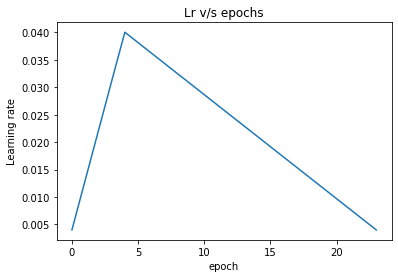

In [11]:
plt.plot(LR)
plt.ylabel('Learning rate')
plt.xlabel("epoch")
plt.title("Lr v/s epochs")
plt.show()

In [14]:
from tqdm import tqdm

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  pbar = tqdm(test_loader)
  for i, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    outputs = model(data)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == target).squeeze()
    for i in range(4):
        label = target[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1
for i in range(10):
  print('Accuracy of %5s : %2d %%' % (labels[i], 100 * class_correct[i] / class_total[i]))

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 20/20 [00:02<00:00,  9.14it/s]

Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 75 %
Accuracy of   cat : 60 %
Accuracy of  deer : 100 %
Accuracy of   dog : 83 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 88 %


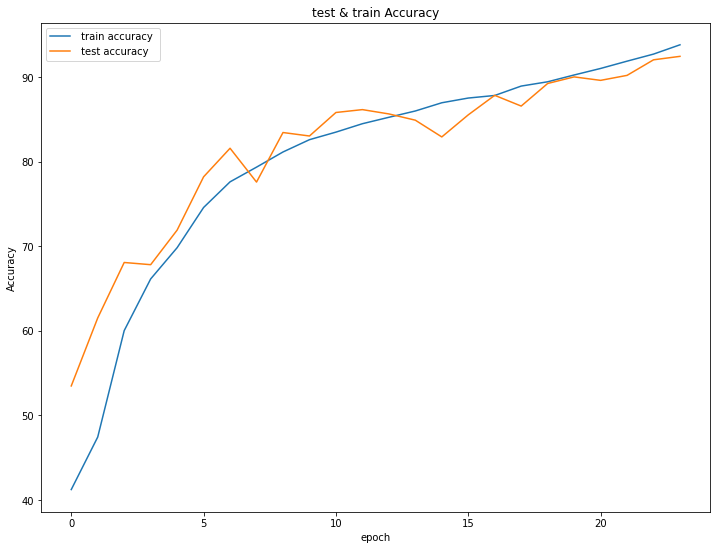

In [16]:
fig, axs = plt.subplots(1,1,figsize=(12,9))
plt.plot(train_acc)
plt.plot(test_acc)

plt.title('test & train Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend([" train accuracy ", ' test accuracy '], loc='best')
plt.show()